# KNN

# Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Configurações visuais
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

# Carga dos dados e Target

In [2]:
df = pd.read_csv('../assets/data.csv', encoding='ISO-8859-1')

df = df.dropna(subset=['CustomerID'])

df['Is_Cancelled'] = df['InvoiceNo'].astype(str).str.upper().str.startswith('C').astype(int)
df['Quantity_Abs'] = df['Quantity'].abs()
df['TotalAmount'] = df['Quantity_Abs'] * df['UnitPrice']


## Exploração

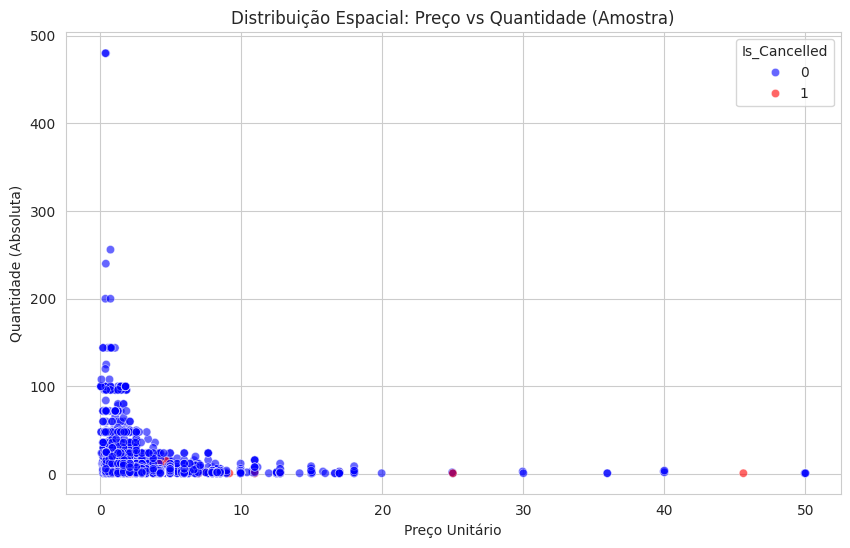

In [3]:
sample_plot = df.sample(5000, random_state=42)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=sample_plot[sample_plot['TotalAmount'] < 200], # Filtro visual para remover outliers extremos
    x='UnitPrice', 
    y='Quantity_Abs', 
    hue='Is_Cancelled',
    palette={0: 'blue', 1: 'red'},
    alpha=0.6
)
plt.title('Distribuição Espacial: Preço vs Quantidade (Amostra)')
plt.xlabel('Preço Unitário')
plt.ylabel('Quantidade (Absoluta)')
plt.show()


## Pré-processamento

In [16]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Hour'] = df['InvoiceDate'].dt.hour
df['Month'] = df['InvoiceDate'].dt.month
df['Country'] = LabelEncoder().fit_transform(df['Country'])


## Divisão treino/teste

In [17]:
features = ['UnitPrice', 'Quantity_Abs', 'TotalAmount', 'Hour', 'Month', 'Country']
X = df[features]
y = df['Is_Cancelled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


## Normalização

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

le = LabelEncoder()
df['Country'] = le.fit_transform(df['Country'])

## Melhor K

K=1: Erro=0.0345
K=3: Erro=0.0228
K=5: Erro=0.0218
K=7: Erro=0.0215
K=9: Erro=0.0215
K=11: Erro=0.0215
K=13: Erro=0.0215
K=15: Erro=0.0217
K=17: Erro=0.0216
K=19: Erro=0.0217


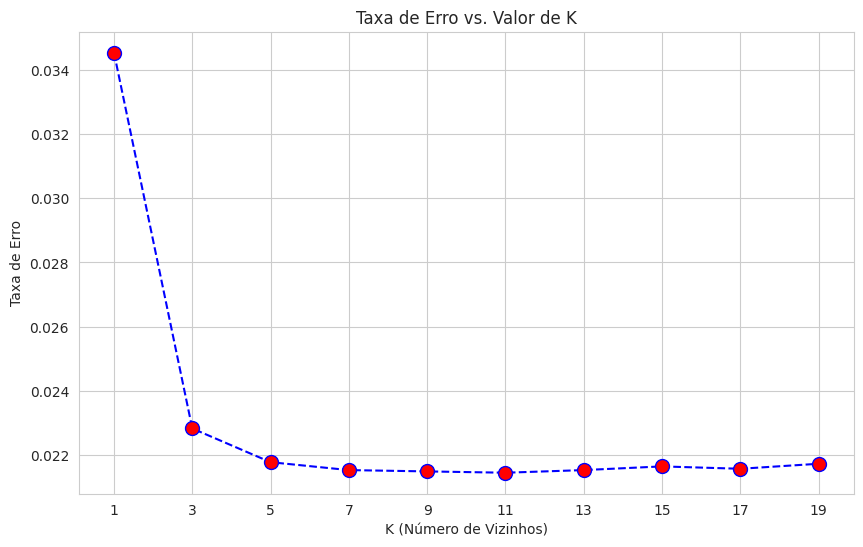

In [27]:
error_rates = []
# Testando apenas K ímpares para evitar empates
k_values = range(1, 20, 2) 

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    # Salvando a taxa de erro (1 - Acurácia)
    error_rates.append(np.mean(pred_i != y_test))
    print(f"K={k}: Erro={error_rates[-1]:.4f}")

# Plot do Cotovelo
plt.figure(figsize=(10, 6))
plt.plot(k_values, error_rates, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Taxa de Erro vs. Valor de K')
plt.xlabel('K (Número de Vizinhos)')
plt.ylabel('Taxa de Erro')
plt.xticks(k_values)
plt.show()

In [22]:
best_k = 11

## Melhor modelo

In [23]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

,n_neighbors,11
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


## Avaliação do modelo

Acurácia: 0.9785

Relatório de Classificação:
              precision    recall  f1-score   support

Venda Normal       0.98      1.00      0.99    119377
Cancelamento       0.62      0.05      0.10      2672

    accuracy                           0.98    122049
   macro avg       0.80      0.53      0.54    122049
weighted avg       0.97      0.98      0.97    122049



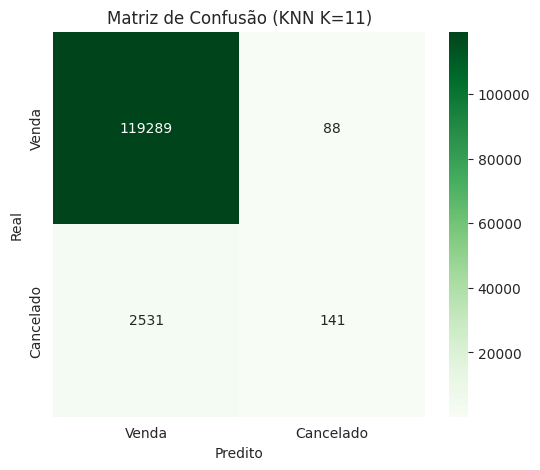

In [24]:
y_pred = knn.predict(X_test)

print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Venda Normal', 'Cancelamento']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Venda', 'Cancelado'], yticklabels=['Venda', 'Cancelado'])
plt.title(f'Matriz de Confusão (KNN K={best_k})')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.show()

## Conclusão e Interpretação dos Resultados (KNN)

Os resultados indicam um cenário de **overfitting em relação à classe majoritária**

### Análise das Métricas
* **Acurácia (97.85%):** O modelo apresentou uma acurácia global extremamente alta. No entanto, dado que a classe de "Venda Normal" representa a vasta maioria dos dados, esse número é enganoso. O modelo atingiu esse patamar classificando quase todas as instâncias como "Venda Normal".

* **Recall de Cancelamento (0.05):** Este é o indicador mais crítico. O modelo foi capaz de identificar apenas **5%** dos cancelamentos reais. Isso demonstra que, no espaço vetorial criado pelas variáveis (Preço, Quantidade, Hora, etc.), os cancelamentos não formam grupos densos e isolados o suficiente para que o critério de "vizinhança" do KNN funcione bem sem tratamentos adicionais.

* **Precision de Cancelamento (0.62):** Apesar do baixo recall, quando o modelo identificou um cancelamento, ele estava correto em 62% das vezes. Isso sugere que ele só "arrisca" a previsão de cancelamento em casos muito óbvios, sendo excessivamente conservador.

Para este conjunto de dados específico, o KNN em sua forma padrão priorizou a especificidade (acertar as vendas normais) em detrimento da sensibilidade (encontrar cancelamentos). A alta dimensionalidade e a dispersão dos dados de cancelamento dificultaram a formação de fronteiras de decisão claras baseadas em distância.